# Setup

In [16]:
#import the necessary modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Raw data download


In [12]:
#Download the data
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0 2341k    0     0  2809k      0  0:04:46 --:--:--  0:04:46 2810k
  1  786M    1 8445k    0     0  4604k      0  0:02:54  0:00:01  0:02:53 4605k
  1  786M    1 14.6M    0     0  5312k      0  0:02:31  0:00:02  0:02:29 5312k
  2  786M    2 20.9M    0     0  5583k      0  0:02:24  0:00:03  0:02:21 5583k
  3  786M    3 26.2M    0     0  5549k      0  0:02:25  0:00:04  0:02:21 5549k
  4  786M    4 32.5M    0     0  5710k      0  0:02:21  0:00:05  0:02:16 6193k
  4  786M    4 38.0M    0     0  5708k      0  0:02:21  0:00:06  0:02:15 6113k
  5  786M    5 44.2M    0     0  5781k      0  0:02:19  0:00:07  0:02:12 6046k
  6  786M    6 50.5M    0     0  5858k      0  0:02:17  0:00:08  0:02:09 6069k
  7  786M    7 56.9M    0     0  5932k      0  0:02

In [13]:
#unzip the downloaded file
!unzip -q kagglecatsanddogs_5340.zip

In [14]:
#show all files
!ls

3D Objects
AndroidStudioProjects
AppData
AppMods
Application Data
CDLA-Permissive-2.0.pdf
Cisco Packet Tracer 7.3.0
Cisco Packet Tracer 7.3.1
Cisco Packet Tracer 8.0
Cisco Packet Tracer 8.0.1
Cisco Packet Tracer 8.1.1
Contacts
Cookies
Desktop
Documents
DohaHoteles.ipynb
Downloads
Favorites
Hotels.ipynb
Image classification from scratch.ipynb
Imbalanced classification credit card fraud detection.ipynb
Intel
IntelGraphicsProfiles
Jedi
Links
Local Settings
Menu DÃ©marrer
Mes documents
MicrosoftEdgeBackups
ModÃ¨les
Music
NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TM.blf
NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TMContainer00000000000000000001.regtrans-ms
NTUSER.DAT{53b39e88-18c4-11ea-a811-000d3aa4692b}.TMContainer00000000000000000002.regtrans-ms
OneDrive
OracleFirdaous.sql
PetImages
Pictures
Postman Agent
Recent
Recorded Calls
Saved Games
Searches
SendTo
Structured data learning with TabTransformer.ipynb
Structured data learning with Wide, Deep, and Cross networks.ipynb
Test.i

In [15]:
!ls PetImages

Cat
Dog


# Filter out corrupted images


In [17]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1578 images


# Generate a Dataset

In [18]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


# Visualize the data

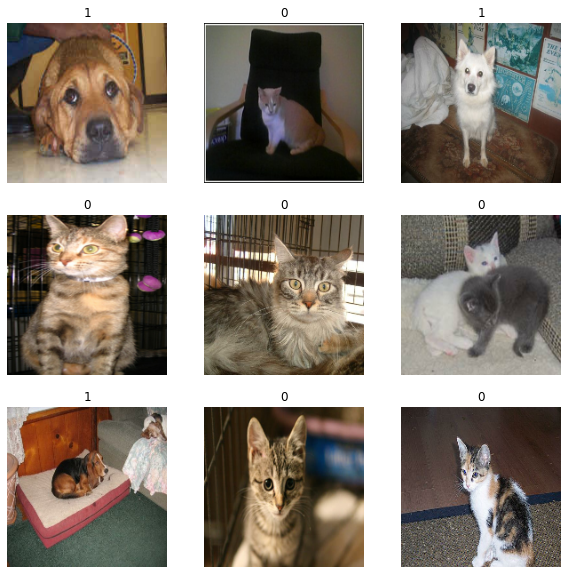

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Using image data augmentation


In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

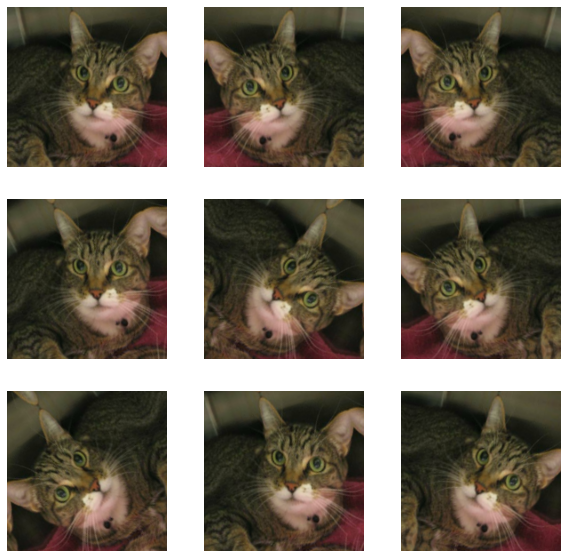

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Two options to preprocess the data
### Option 1: Make it part of the model, like this:




In [22]:
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model

NameError: name 'input_shape' is not defined

### Option 2: apply it to the dataset

In [23]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

# Configure the dataset for performance


In [24]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Build a model


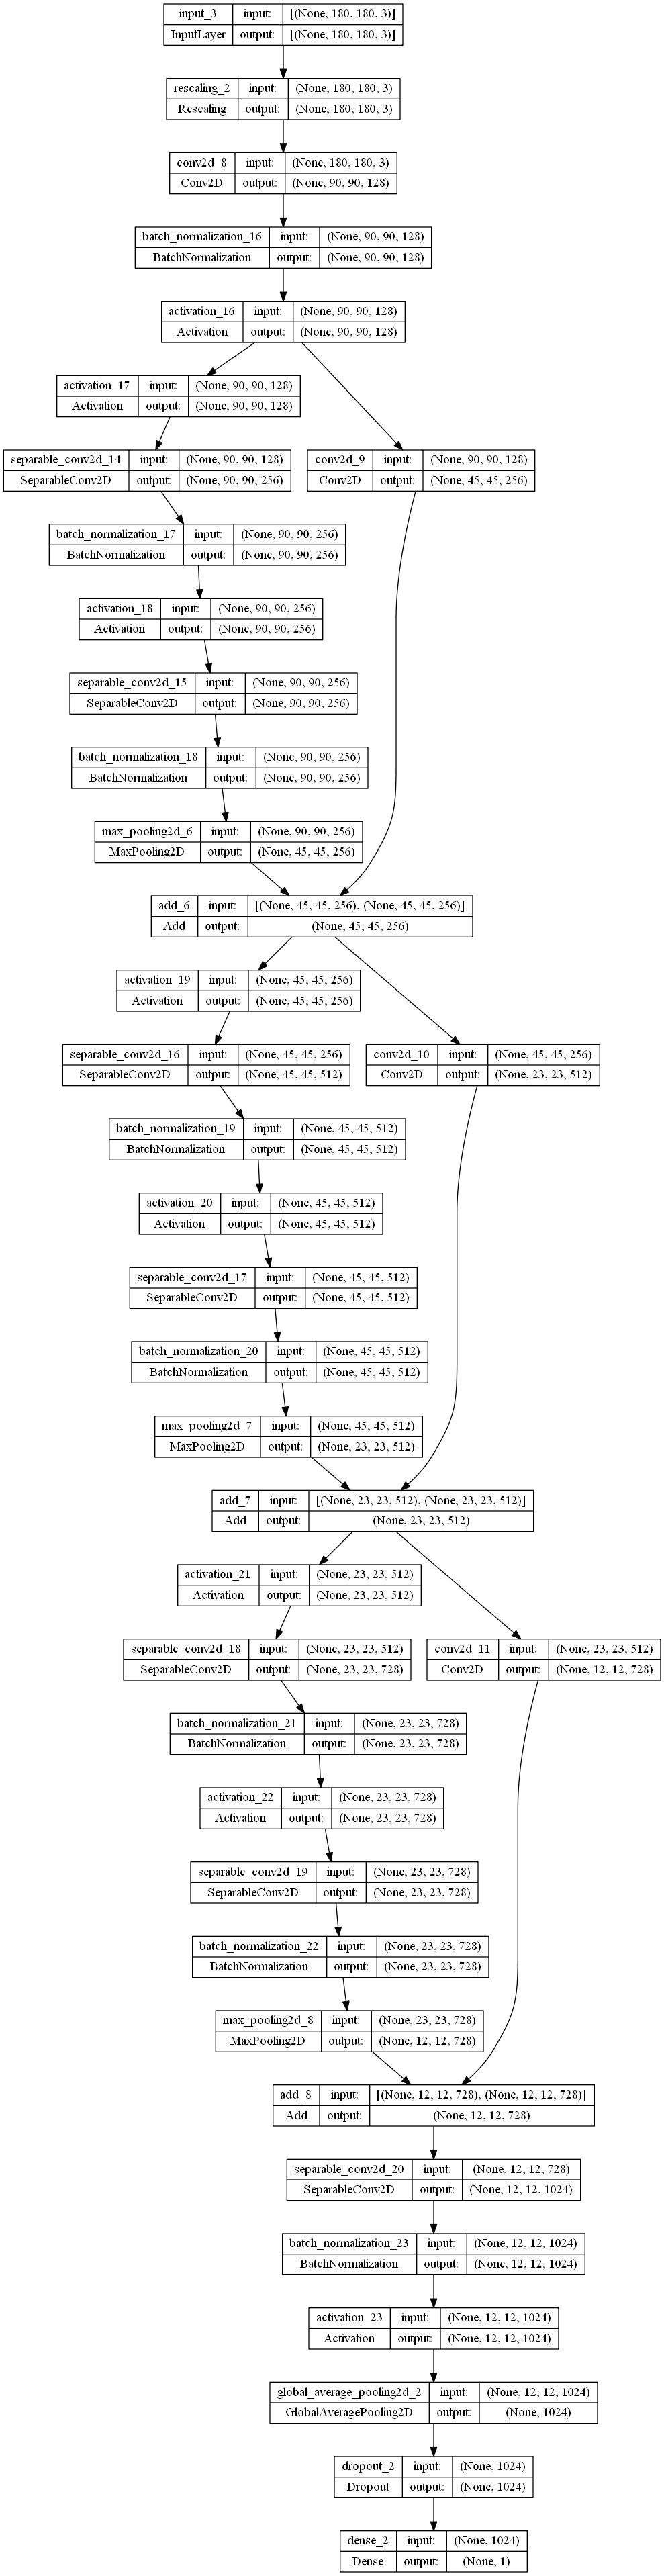

In [27]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# Train the model


In [ ]:

epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
  1/147 [..............................] - ETA: 4:39:51 - loss: 0.7167 - accuracy: 0.6562

# Run inference on new data


In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")